In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from preprocess import *
from utils import *

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Image loading and preprocessing


In [5]:
crop_size = (256, 256)

def preprocess_generator_train_test(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], crop_size[0], crop_size[1], 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = crop_img(batch[i], crop_size)
            batch_crops[i] = center_img(batch_crops[i]) # shift to -1,1
        yield batch_crops, batch_crops


def preprocess_generator_slice(generator):
    while True:
        batch = next(generator)
        for img in batch:
            img = center_img(img)
            yield slice_img(img, crop_size)


### 720p
image_width_target = 1280 // 2
image_height_target = 720 // 2

train_ds, test_ds = create_dataflows('../images/HollowKnight/', (image_height_target, image_width_target), 16)

train_ds_prep = preprocess_generator_train_test(train_ds)
test_ds_prep = preprocess_generator_train_test(test_ds)

### 1080p
# image_width_target = 1280
# image_height_target = 720
#
# train_ds, test_ds = create_dataflows('../images/HollowKnight-1080p/', (image_height_target, image_width_target), 16)
#
# train_ds_prep = preprocess_generator_train_test(train_ds)
# test_ds_prep = preprocess_generator_train_test(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


In [ ]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(decenter_img(image))
    plt.axis("off")

train_ds.reset()

# The Model of the AutoEncoder

In [7]:
def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(decenter_img(y_true), decenter_img(y_pred), 1.0, filter_size=3))

In [8]:
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from keras.models import Model, Sequential

def create_improved_baseline_model_12x_comp(image_size):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_size[0], image_size[1], 3)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='tanh', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

In [9]:
autoencoder = create_improved_baseline_model_12x_comp(crop_size)
# autoencoder.summary()

('shape of encoded', (None, 32, 32, 8))
('shape of decoded', (None, 256, 256, 3))


In [10]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0025), loss=ssim_loss)

# Training the AutoEncoder

In [ ]:
# Note: Delete the logs before running this. The command below should do this, but I would prefer to do it manually.
# !RMDIR "./logs/" /S /Q

# Launching Tensorboard
%tensorboard --logdir ./logs/fit --host localhost #--port:6006
# localhost:6006 in browser

In [12]:
from keras.callbacks import CSVLogger, TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Set APPEND=TRUE if you are continuing the training, so that the log.csv wouldn't be reset!
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [ ]:
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=100,
                callbacks=[csv_logger, tensorboard_callback],
                verbose=1)

In [ ]:
# Saving the model:
# autoencoder.save('../model-saves/featuremap-size-test/24x24x8-complex-decoder')

In [ ]:
# Loading the model:
# autoencoder = keras.models.load_model('../model-saves/featuremap-size-test/24x24x8-complex-decoder', custom_objects={
#     'ssim_loss': ssim_loss
# })
#
# autoencoder.summary()

# Running the AutoEncoder

In [18]:
img_number = 4
display_img_number = 4

test_set = []
for i in range(img_number):
    test_set.append(next(preprocess_generator_slice(test_ds)))

1/1 [==============================] - 0s 22ms/step
0.018935025
1/1 [==============================] - 0s 20ms/step
0.01680392
1/1 [==============================] - 0s 24ms/step
0.051564395
1/1 [==============================] - 0s 21ms/step
0.025933921
AVERAGE SSIM: 
0.028309315


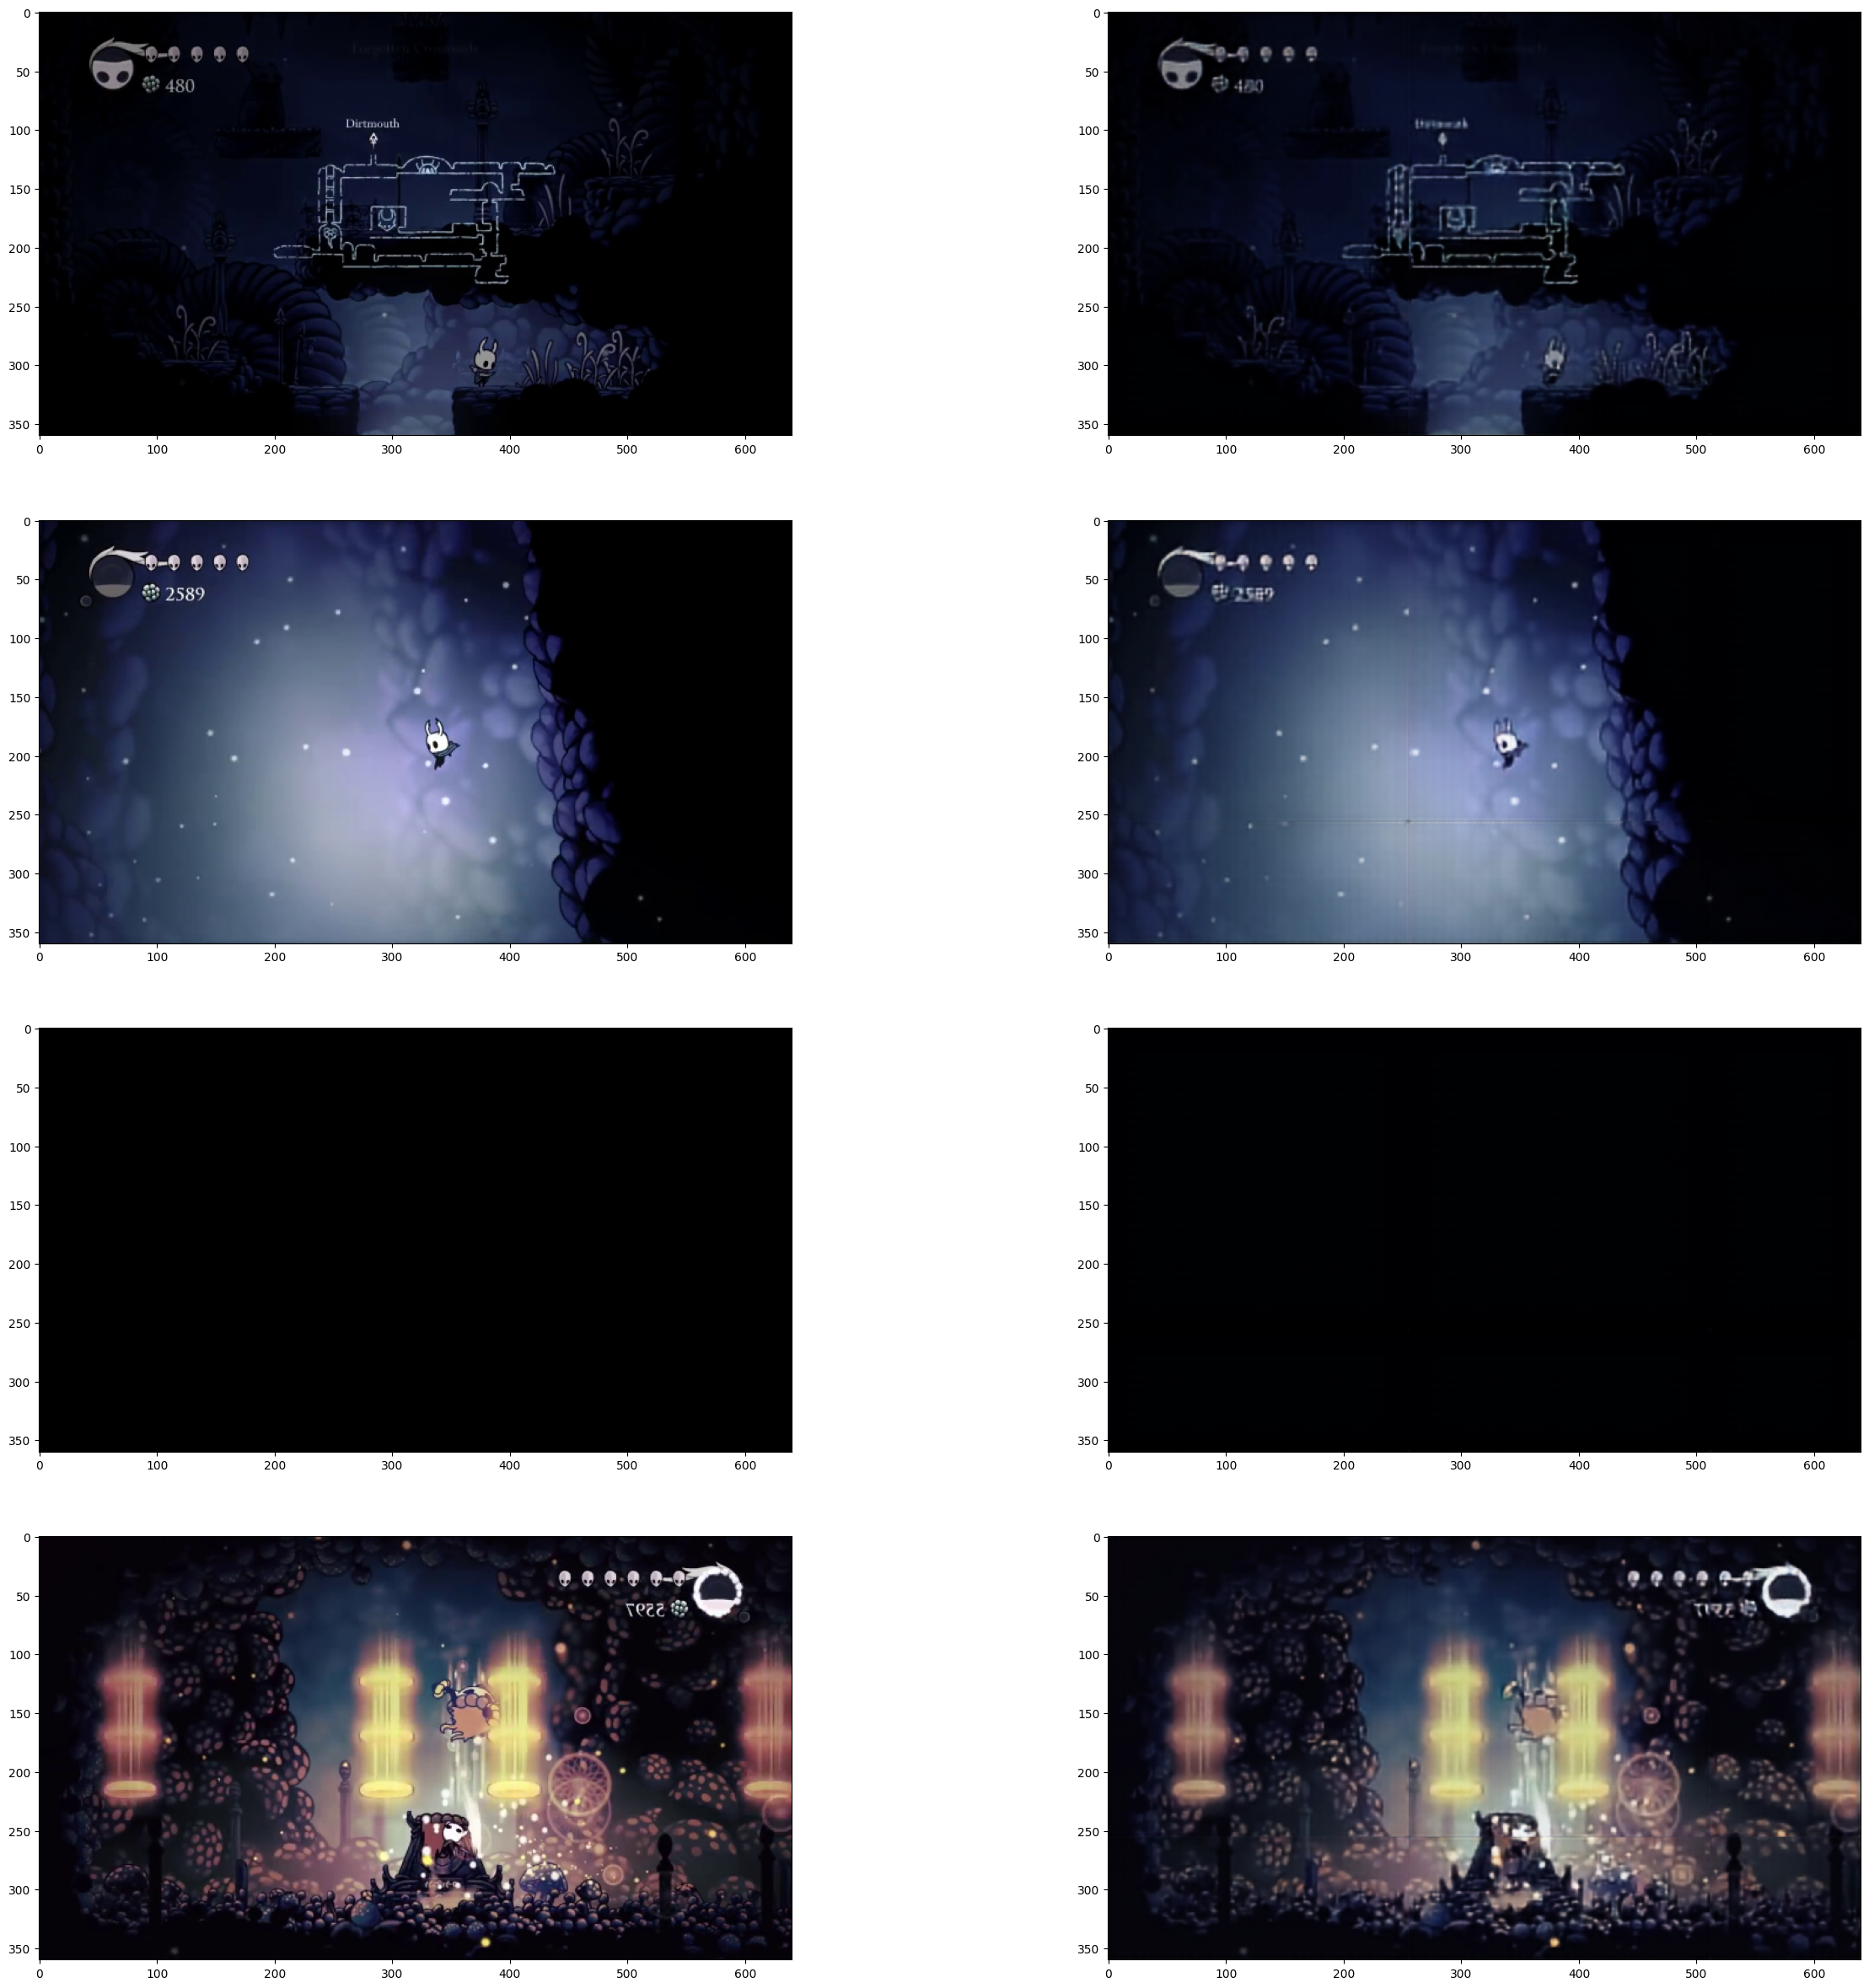

In [19]:
img_size = (image_height_target, image_width_target, 3)

fig = plt.figure(figsize=(30, 30))

ssim_values = []
for i in range(img_number):
    image_slices = test_set[i]

    decoded_slices = autoencoder.predict(image_slices)
    decoded_img = deslice_img(decoded_slices, img_size)
    decoded_img = decenter_img(decoded_img)

    original_image = decenter_img(deslice_img(image_slices, img_size))

    ssim = 1 - tensorflow.image.ssim_multiscale(original_image, decoded_img, 1.0, filter_size=3)
    ssim_values.append(ssim)
    print(ssim.numpy())

    if i < display_img_number:
        plt.subplot(display_img_number, 2, i*2+1)
        plt.imshow(original_image)
        plt.subplot(display_img_number, 2, i*2+2)
        plt.imshow(decoded_img)

print("AVERAGE SSIM: ")
print(np.array(ssim_values).mean())

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))

## Visualize the individual tiles

1/1 [==============================] - 0s 23ms/step


ValueError: num must be 1 <= num <= 8, not 9

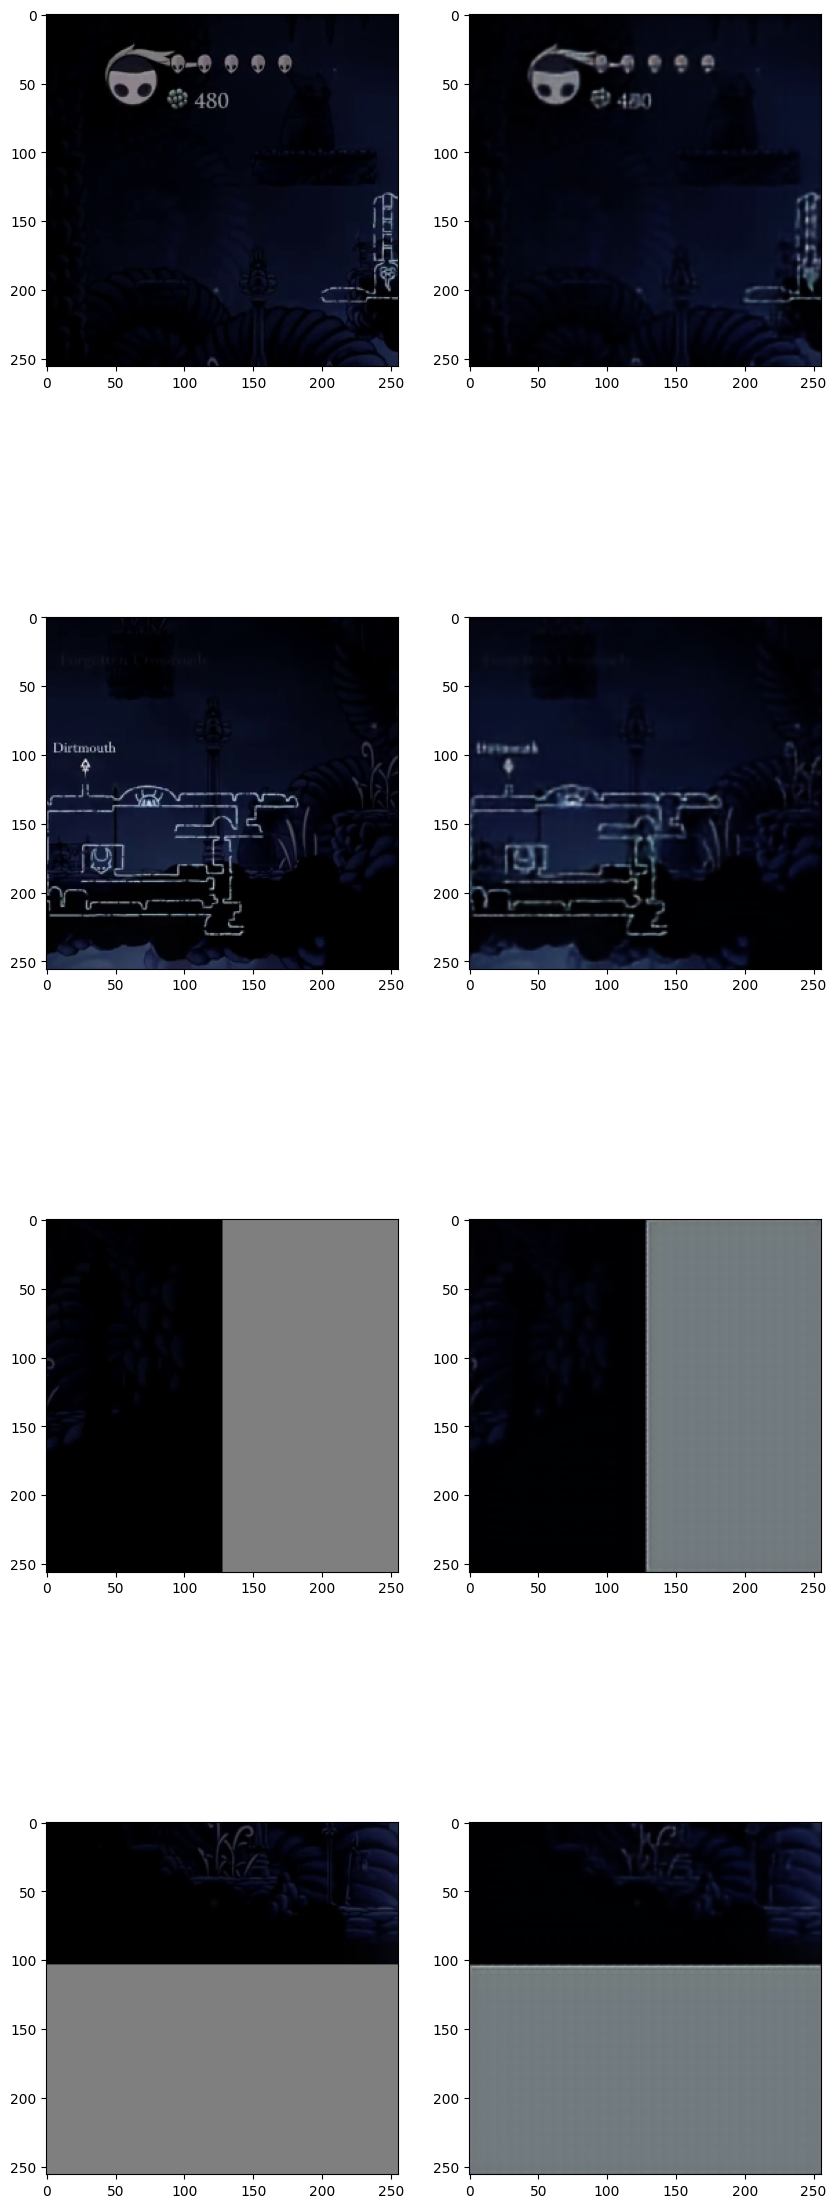

In [20]:
img_size = (image_height_target, image_width_target, 3)

fig = plt.figure(figsize=(10, 30))

image_slices = test_set[0]
decoded_slices = autoencoder.predict(image_slices)

for i in range(len(decoded_slices)):
    original_image = decenter_img(decoded_slices[i])

    plt.subplot(display_img_number, 2, i*2+1)
    plt.imshow(decenter_img(test_set[0][i]))
    plt.subplot(display_img_number, 2, i*2+2)
    plt.imshow(decenter_img(decoded_slices[i]))

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))

## Compare original/decoded/jpeg images

In [21]:
from pathlib import Path
from keras.utils import load_img, save_img, img_to_array

img_size = (image_height_target, image_width_target, 3)

encoder, decoder = split_autoencoder(autoencoder)

output_path = "./output/"
# fig = plt.figure(figsize=(30, 30))

tf.compat.v1.enable_eager_execution()

for i in range(display_img_number):
    print(i)

    path = output_path + str(i) + "_"

    original_path = path + "original.jpg"
    encoded_path = path + "encoded.npy"
    decoded_path = path + "decoded.jpg"
    jpeg_path = path + "jpeg.jpg"

    # Original image
    image_slices = test_set[i]
    original_img = decenter_img(deslice_img(image_slices, img_size))
    save_img(original_path, original_img)
    # print("Original min,max,avg",original_img.min(), original_img.mean(), original_img.max())

    # Encoed image
    encoded_slices = encoder.predict(image_slices)
    save_encoded(encoded_slices, encoded_path)

    decoded_slices = decoder.predict(encoded_slices)
    decoded_img = decenter_img(deslice_img(decoded_slices, img_size))
    save_img(decoded_path, decoded_img)
    # print("Decoded min,max,avg", decoded_img.min(), decoded_img.mean(), decoded_img.max())

    encoded_file_size = Path(encoded_path).stat().st_size * 8
    bpp = float(encoded_file_size) / (image_height_target * image_width_target)
    ssim = 1 - tensorflow.image.ssim_multiscale(original_img, decoded_img, 1.0, filter_size=3)

    # JPEG compressed
    original_bgr = original_img.copy()[...,::-1] * 255
    cv2.imwrite(jpeg_path, original_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), 50])

    jpeg_img = img_to_array(load_img(jpeg_path)).astype('float64') / 255
    # print("JPEG min,max,avg", jpeg_img.min(), jpeg_img.mean(), jpeg_img.max())
    # print("OriG min,max,avg",original_img.min(), original_img.mean(), original_img.max())

    jpeg_file_size = Path(jpeg_path).stat().st_size * 8
    bpp_j = float(jpeg_file_size) / (image_height_target * image_width_target)
    ssim_j = 1 - tensorflow.image.ssim_multiscale(original_img, jpeg_img, 1.0, filter_size=3)

    # Results
    print("BPP of encoded:", bpp)
    print("SSIM of decoded:", float(ssim))
    print("BPP of jpeg:", bpp_j)
    print("SSIM of jpeg:", float(ssim_j))
    print()

0
1/1 [==============================] - 0s 206ms/step
BPP of encoded: 3.417777777777778
SSIM of decoded: 0.018935024738311768
BPP of jpeg: 0.47215277777777775
SSIM of jpeg: 0.015873372554779053

1
1/1 [==============================] - 0s 18ms/step
BPP of encoded: 3.417777777777778
SSIM of decoded: 0.01680392026901245
BPP of jpeg: 0.36086805555555557
SSIM of jpeg: 0.012385845184326172

2
1/1 [==============================] - 0s 17ms/step
BPP of encoded: 3.417777777777778
SSIM of decoded: 0.05156439542770386
BPP of jpeg: 0.14954861111111112
SSIM of jpeg: 0.0

3
1/1 [==============================] - 0s 17ms/step
BPP of encoded: 3.417777777777778
SSIM of decoded: 0.025933921337127686
BPP of jpeg: 0.7998958333333334
SSIM of jpeg: 0.020573318004608154

